# 08: Stacked Blocks

*The fish grows longer.*

---

We have a transformer block. It works. The obvious question: what if we use two?

This is how depth happens. Each block:
1. Gathers information from context (attention)
2. Thinks about what it gathered (FFN)
3. Adds its contribution to the residual stream

With two blocks, the second block sees the *output* of the first. It can:
- Attend based on features the first block computed
- Build higher-level abstractions
- Refine and correct the first block's work

This is hierarchical processing. Block 1 might learn "these words go together." Block 2 might learn "this phrase modifies that phrase."

The code change is minimal—that's the payoff of the residual architecture. Blocks are composable. You just stack them.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
import math

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

Using device: mps


---

## 1. Data and Tokenizer

In [10]:
from transformers import GPT2TokenizerFast

class LilTokenizer:
    """Compact tokenizer for Lil Transformy."""
    
    def __init__(self, gpt2_to_compact, compact_to_gpt2, vocab_size):
        self.gpt2_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
        self.gpt2_to_compact = gpt2_to_compact
        self.compact_to_gpt2 = compact_to_gpt2
        self.vocab_size = vocab_size
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
    
    def encode(self, text, add_eos=True):
        gpt2_tokens = self.gpt2_tokenizer.encode(text)
        compact_tokens = [self.gpt2_to_compact.get(t, self.unk_id) for t in gpt2_tokens]
        if add_eos:
            compact_tokens.append(self.eos_id)
        return compact_tokens
    
    def decode(self, token_ids):
        gpt2_tokens = []
        for tid in token_ids:
            if tid in [self.pad_id, self.unk_id, self.eos_id]:
                continue
            if tid in self.compact_to_gpt2:
                gpt2_tokens.append(self.compact_to_gpt2[tid])
        return self.gpt2_tokenizer.decode(gpt2_tokens)
    
    def __len__(self):
        return self.vocab_size
    
    @classmethod
    def load(cls, path):
        with open(path, 'r') as f:
            config = json.load(f)
        gpt2_to_compact = {int(k): v for k, v in config['gpt2_to_compact'].items()}
        compact_to_gpt2 = {int(k): v for k, v in config['compact_to_gpt2'].items()}
        return cls(gpt2_to_compact, compact_to_gpt2, config['vocab_size'])


tokenizer = LilTokenizer.load('tokenizer/tokenizer.json')
print(f"Vocabulary size: {len(tokenizer):,}")

Vocabulary size: 4,096


In [11]:
train_data = np.load('data/train_sequences.npy')
val_data = np.load('data/val_sequences.npy')

print(f"Training sequences: {train_data.shape}")
print(f"Validation sequences: {val_data.shape}")
print(f"Context length: {train_data.shape[1]}")

Training sequences: (1851532, 256)
Validation sequences: (18616, 256)
Context length: 256


---

## 2. The Architecture

Same components as notebook 07, but now we stack multiple blocks.

```
Tokens → Embed + Position → Block₁ → Block₂ → ... → LayerNorm → Unembed
```

The key insight: each block operates on the residual stream. Block 2 sees Block 1's contributions. Block 3 would see both. And so on.

In [12]:
class CausalSelfAttention(nn.Module):
    """Single-head causal self-attention."""
    
    def __init__(self, d_model, max_seq_len=256):
        super().__init__()
        self.d_model = d_model
        
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1).bool()
        self.register_buffer('mask', mask)
        self.scale = math.sqrt(d_model)
    
    def forward(self, x):
        B, T, C = x.shape
        
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        
        scores = (Q @ K.transpose(-2, -1)) / self.scale
        scores = scores.masked_fill(self.mask[:T, :T], float('-inf'))
        attn = F.softmax(scores, dim=-1)
        
        return self.W_o(attn @ V)


class FeedForward(nn.Module):
    """Position-wise feedforward network."""
    
    def __init__(self, d_model, d_ff=None):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))


class TransformerBlock(nn.Module):
    """A single transformer block (pre-norm architecture)."""
    
    def __init__(self, d_model, d_ff=None, max_seq_len=256):
        super().__init__()
        
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.attention = CausalSelfAttention(d_model, max_seq_len)
        self.ffn = FeedForward(d_model, d_ff)
    
    def forward(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x

In [13]:
class StackedTransformerLM(nn.Module):
    """
    Language model with stacked transformer blocks.
    
    Architecture:
        Tokens → Embed + Position → Block₁ → Block₂ → ... → LayerNorm → Unembed
    
    This is a proper (small) transformer. The only thing missing is multi-head attention.
    """
    
    def __init__(self, vocab_size, d_model, n_layers, d_ff=None, max_seq_len=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.max_seq_len = max_seq_len
        
        if d_ff is None:
            d_ff = 4 * d_model
        self.d_ff = d_ff
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
        
        # Stack of transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, d_ff, max_seq_len)
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.ln_final = nn.LayerNorm(d_model)
        
        # Output
        self.unembed = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        """
        Args:
            x: Token IDs, shape [batch, seq_len]
        Returns:
            Logits, shape [batch, seq_len, vocab_size]
        """
        B, T = x.shape
        
        # Embed tokens and positions
        tok_emb = self.token_embedding(x)
        pos_emb = self.position_embedding(torch.arange(T, device=x.device))
        x = tok_emb + pos_emb
        
        # Pass through all blocks
        for block in self.blocks:
            x = block(x)
        
        # Final norm and output
        x = self.ln_final(x)
        logits = self.unembed(x)
        
        return logits
    
    def generate(self, prompt_tokens, max_new_tokens=50, temperature=1.0):
        """Generate tokens autoregressively."""
        self.eval()
        tokens = list(prompt_tokens)
        generated = []
        
        with torch.no_grad():
            for _ in range(max_new_tokens):
                context = tokens[-self.max_seq_len:]
                x = torch.tensor([context], device=next(self.parameters()).device)
                
                logits = self.forward(x)
                next_logits = logits[0, -1]
                
                probs = F.softmax(next_logits / temperature, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1).item()
                
                generated.append(next_token)
                tokens.append(next_token)
                
                if next_token == 2:  # EOS
                    break
        
        return generated

In [14]:
# === Model Parameters ===
VOCAB_SIZE = len(tokenizer)  # 4096
D_MODEL = 128
D_FF = 4 * D_MODEL  # 512
N_LAYERS = 2  # <-- THE NEW THING
MAX_SEQ_LEN = 256

# Create model
model = StackedTransformerLM(VOCAB_SIZE, D_MODEL, N_LAYERS, D_FF, MAX_SEQ_LEN).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
block_params = sum(p.numel() for p in model.blocks[0].parameters())

print(f"Total parameters: {num_params:,}")
print()
print("Breakdown:")
print(f"  Token embedding:    {VOCAB_SIZE * D_MODEL:,}")
print(f"  Position embedding: {MAX_SEQ_LEN * D_MODEL:,}")
print(f"  Transformer blocks: {N_LAYERS} × {block_params:,} = {N_LAYERS * block_params:,}")
print(f"  Final LayerNorm:    {2 * D_MODEL}")
print(f"  Unembed:            {D_MODEL * VOCAB_SIZE + VOCAB_SIZE:,}")
print()
print(f"Notebook 07 (1 block) had 1,283,456 params.")
print(f"We added {block_params:,} params for the second block.")

Total parameters: 1,481,216

Breakdown:
  Token embedding:    524,288
  Position embedding: 32,768
  Transformer blocks: 2 × 197,760 = 395,520
  Final LayerNorm:    256
  Unembed:            528,384

Notebook 07 (1 block) had 1,283,456 params.
We added 197,760 params for the second block.


---

## 3. Training

Same setup as before. 1 epoch, same data, same hyperparameters. Only the architecture changed.

In [15]:
# === Training Parameters ===
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
NUM_EPOCHS = 1
EVAL_EVERY = 500

def make_batch(data, batch_indices):
    """Create a training batch."""
    sequences = data[batch_indices]
    x = torch.tensor(sequences[:, :-1], dtype=torch.long, device=device)
    y = torch.tensor(sequences[:, 1:], dtype=torch.long, device=device)
    return x, y

def evaluate(model, data, num_batches=50):
    """Evaluate model on validation data."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    indices = np.random.choice(len(data), size=num_batches * BATCH_SIZE, replace=False)
    
    with torch.no_grad():
        for i in range(num_batches):
            batch_idx = indices[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
            x, y = make_batch(data, batch_idx)
            
            logits = model(x)
            logits_flat = logits.view(-1, VOCAB_SIZE)
            y_flat = y.view(-1)
            
            loss = F.cross_entropy(logits_flat, y_flat)
            
            total_loss += loss.item() * y_flat.numel()
            total_tokens += y_flat.numel()
    
    model.train()
    avg_loss = total_loss / total_tokens
    return {'loss': avg_loss, 'perplexity': math.exp(avg_loss)}


# Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps = steps_per_epoch * NUM_EPOCHS

print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total steps: {total_steps:,}")

Steps per epoch: 28,930
Total steps: 28,930


In [16]:
# Training loop
history = {'train_loss': [], 'val_loss': [], 'val_perplexity': []}

print("Starting training...")
print("=" * 60)

step = 0
running_loss = 0

for epoch in range(NUM_EPOCHS):
    perm = np.random.permutation(len(train_data))
    epoch_pbar = tqdm(range(steps_per_epoch), desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    for batch_num in epoch_pbar:
        batch_idx = perm[batch_num * BATCH_SIZE:(batch_num + 1) * BATCH_SIZE]
        x, y = make_batch(train_data, batch_idx)
        
        optimizer.zero_grad()
        logits = model(x)
        
        logits_flat = logits.view(-1, VOCAB_SIZE)
        y_flat = y.view(-1)
        loss = F.cross_entropy(logits_flat, y_flat)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        step += 1
        
        if step % EVAL_EVERY == 0:
            avg_train_loss = running_loss / EVAL_EVERY
            val_metrics = evaluate(model, val_data)
            
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_metrics['loss'])
            history['val_perplexity'].append(val_metrics['perplexity'])
            
            epoch_pbar.set_postfix({
                'loss': f"{avg_train_loss:.3f}",
                'val_loss': f"{val_metrics['loss']:.3f}",
                'ppl': f"{val_metrics['perplexity']:.1f}"
            })
            
            running_loss = 0

print("\nTraining complete!")

Starting training...


Epoch 1/1:   0%|          | 0/28930 [00:00<?, ?it/s]


Training complete!


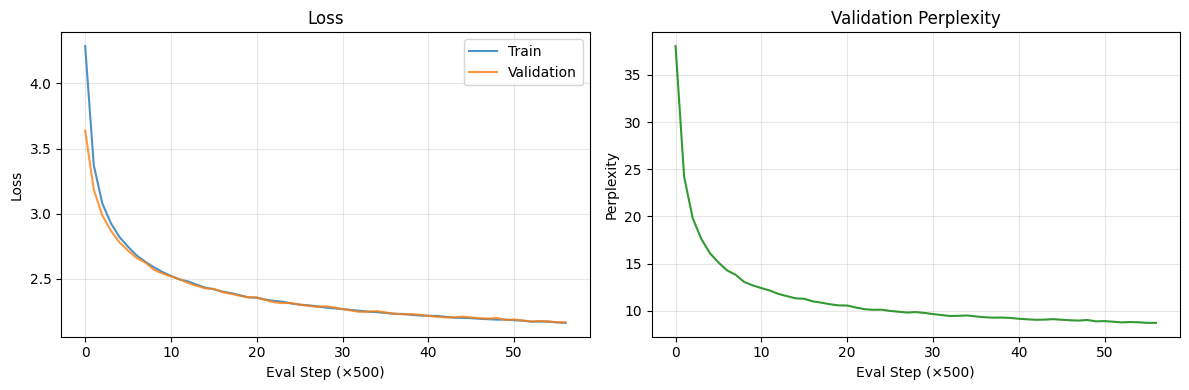


Final validation loss: 2.167
Final validation perplexity: 8.7


In [17]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train', alpha=0.8)
axes[0].plot(history['val_loss'], label='Validation', alpha=0.8)
axes[0].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['val_perplexity'], color='green', alpha=0.8)
axes[1].set_xlabel(f'Eval Step (×{EVAL_EVERY})')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Validation Perplexity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('08_training_curves.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFinal validation loss: {history['val_loss'][-1]:.3f}")
print(f"Final validation perplexity: {history['val_perplexity'][-1]:.1f}")

---

## 4. Comparison

In [18]:
# Load previous results
checkpoint_03 = torch.load('03_bigram.pt', map_location='cpu', weights_only=False)
checkpoint_04 = torch.load('04_attention.pt', map_location='cpu', weights_only=False)
checkpoint_05 = torch.load('05_positional.pt', map_location='cpu', weights_only=False)
checkpoint_06 = torch.load('06_ffn.pt', map_location='cpu', weights_only=False)
checkpoint_07 = torch.load('07_transformer_block.pt', map_location='cpu', weights_only=False)

print("=" * 70)
print("COMPARISON")
print("=" * 70)
print()
print(f"{'Model':<35} {'Params':<15} {'Epochs':<8} {'Val PPL':<10}")
print("-" * 70)
print(f"{'03: Bigram':<35} {'1,052,672':<15} {'1':<8} {checkpoint_03['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'04: + Attention':<35} {'1,118,208':<15} {'3':<8} {checkpoint_04['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'05: + Position':<35} {'1,151,104':<15} {'1':<8} {checkpoint_05['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'06: + FFN':<35} {'1,282,048':<15} {'1':<8} {checkpoint_06['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'07: + Residual & LayerNorm':<35} {'1,283,456':<15} {'1':<8} {checkpoint_07['history']['val_perplexity'][-1]:<10.1f}")
print(f"{'08: 2 Blocks (this)':<35} {f'{num_params:,}':<15} {'1':<8} {history['val_perplexity'][-1]:<10.1f}")
print()
print("Depth helps. Each block refines the representation further.")

COMPARISON

Model                               Params          Epochs   Val PPL   
----------------------------------------------------------------------
03: Bigram                          1,052,672       1        35.8      
04: + Attention                     1,118,208       3        25.0      
05: + Position                      1,151,104       1        17.7      
06: + FFN                           1,282,048       1        13.4      
07: + Residual & LayerNorm          1,283,456       1        10.9      
08: 2 Blocks (this)                 1,481,216       1        8.7       

Depth helps. Each block refines the representation further.


---

## 5. Generation

In [19]:
def generate_and_print(prompt, max_tokens=50, temperature=1.0):
    """Generate from a prompt and print results."""
    prompt_tokens = tokenizer.encode(prompt, add_eos=False)
    generated_tokens = model.generate(prompt_tokens, max_new_tokens=max_tokens, temperature=temperature)
    generated_text = tokenizer.decode(generated_tokens)
    
    print(f"Prompt: {prompt}")
    print(f"Generated: {generated_text}")
    print()


print("=" * 60)
print("GENERATION TEST")
print("=" * 60)
print()

test_prompts = [
    "Once upon a time",
    "The little girl",
    "Once upon a time there was a little girl named Lily. She",
    "The boy was sad because his toy was broken. His mom said",
]

for prompt in test_prompts:
    generate_and_print(prompt, max_tokens=40)

GENERATION TEST

Prompt: Once upon a time
Generated:  there were two twins, Missgy and the boy named Remy. Remy was very good at safari. They loved to play and unpackoc. Every morning, Remy would rise with lots

Prompt: The little girl
Generated:  said, "We are gathering toast from this second! We both said to each other, we are just looking for a picnic instead." 

So, it started to set up the timer go

Prompt: Once upon a time there was a little girl named Lily. She
Generated:  loved to eat animals and play with her toys sometimes. One day, her mom told her to stay safe and went outside to play. Lily's mom told her to be careful and not to be her

Prompt: The boy was sad because his toy was broken. His mom said
Generated: , "Timmy, I'm crying. I will help you find a new toy. It has many toys that are books there."

Timmy's mom took the toy by and went to



---

## 6. Visualizing Layer Contributions

With two blocks, we can see how each layer contributes to the final representation.

In [20]:
def analyze_layer_contributions(text):
    """
    Show how the representation changes as it passes through each block.
    """
    tokens = tokenizer.encode(text, add_eos=False)
    x = torch.tensor([tokens], device=device)
    
    model.eval()
    with torch.no_grad():
        B, T = x.shape
        
        # Embedding
        tok_emb = model.token_embedding(x)
        pos_emb = model.position_embedding(torch.arange(T, device=device))
        after_embed = tok_emb + pos_emb
        
        # Block 1
        after_block1 = model.blocks[0](after_embed)
        
        # Block 2
        after_block2 = model.blocks[1](after_block1)
        
        # Final norm
        final = model.ln_final(after_block2)
    
    # Compute what each block added
    block1_contribution = after_block1 - after_embed
    block2_contribution = after_block2 - after_block1
    
    print(f"Text: {text}")
    print(f"Tokens: {len(tokens)}")
    print()
    print("Representation norm at each stage (averaged over positions):")
    print("-" * 50)
    
    for name, tensor in [
        ('After embedding', after_embed),
        ('After block 1', after_block1),
        ('After block 2', after_block2),
        ('After final norm', final),
    ]:
        norms = tensor[0].norm(dim=-1)
        print(f"  {name:<20}: mean={norms.mean():.2f}, std={norms.std():.2f}")
    
    print()
    print("What each block added (norm of contribution):")
    print("-" * 50)
    print(f"  Block 1 contribution: {block1_contribution[0].norm(dim=-1).mean():.2f}")
    print(f"  Block 2 contribution: {block2_contribution[0].norm(dim=-1).mean():.2f}")


analyze_layer_contributions("Once upon a time there was a little girl")

Text: Once upon a time there was a little girl
Tokens: 9

Representation norm at each stage (averaged over positions):
--------------------------------------------------
  After embedding     : mean=13.33, std=4.19
  After block 1       : mean=45.61, std=15.12
  After block 2       : mean=58.89, std=10.90
  After final norm    : mean=16.55, std=0.93

What each block added (norm of contribution):
--------------------------------------------------
  Block 1 contribution: 41.63
  Block 2 contribution: 51.78


---

## Summary

### What We Added

A second transformer block. That's it. The code change was minimal:

```python
# Before (notebook 07)
self.block = TransformerBlock(d_model, d_ff, max_seq_len)

# After (this notebook)
self.blocks = nn.ModuleList([
    TransformerBlock(d_model, d_ff, max_seq_len)
    for _ in range(n_layers)
])
```

### Why Depth Helps

Each block operates on the residual stream. Block 2 sees Block 1's contributions and can:
- Build on patterns Block 1 found
- Refine or correct Block 1's work
- Learn higher-level abstractions

This is hierarchical processing. The blocks specialize and cooperate.

### What's Next

- **Multi-head attention:** Instead of one attention pattern per block, learn multiple patterns in parallel (notebook 09)

After that, we'll have a complete (tiny) transformer. Same architecture as GPT-2, just smaller.

In [21]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'vocab_size': VOCAB_SIZE,
    'd_model': D_MODEL,
    'd_ff': D_FF,
    'n_layers': N_LAYERS,
    'max_seq_len': MAX_SEQ_LEN,
    'history': history,
}

torch.save(checkpoint, '08_stacked.pt')
print("Model saved to 08_stacked.pt")

Model saved to 08_stacked.pt


In [22]:
print("=" * 60)
print("NOTEBOOK 08 COMPLETE")
print("=" * 60)
print(f"\nArchitecture: Embed + Position → Block × {N_LAYERS} → Unembed")
print(f"Parameters: {num_params:,}")
print(f"Training: {NUM_EPOCHS} epoch")
print(f"Final perplexity: {history['val_perplexity'][-1]:.1f}")
print()
print("The fish crawled onto land.")
print("Next: Multi-head attention. The lizard grows a bigger brain.")

NOTEBOOK 08 COMPLETE

Architecture: Embed + Position → Block × 2 → Unembed
Parameters: 1,481,216
Training: 1 epoch
Final perplexity: 8.7

The fish crawled onto land.
Next: Multi-head attention. The lizard grows a bigger brain.
